<a href="https://colab.research.google.com/github/chunjie-sam-liu/TEP-prognosis/blob/main/test/pytorchstepbystep04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
try:
    import google.colab
    import requests
    url = 'https://raw.githubusercontent.com/dvgodoy/PyTorchStepByStep/master/config.py'
    r = requests.get(url, allow_redirects=True)
    open('config.py', 'wb').write(r.content)    
except ModuleNotFoundError:
    pass

from config import *
config_chapter4()
# This is needed to render the plots in this chapter
from plots.chapter4 import *

Finished!


In [3]:
import random
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, WeightedRandomSampler, SubsetRandomSampler
from torchvision.transforms import Compose, ToTensor, Normalize, ToPILImage, RandomHorizontalFlip, Resize

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
%matplotlib inline

from data_generation.image_classification import generate_dataset
from stepbystep.v0 import StepByStep
from plots.chapter4 import *

In [4]:
images, labels = generate_dataset(img_size=5, n_images=300, binary=True, seed=13)

In [5]:
print(images.shape, labels.shape, labels[:10], sep='\n')

(300, 1, 5, 5)
(300,)
[0 1 1 1 1 1 1 1 0 0]


In [6]:
print(images[:2])

[[[[  0   0 255   0   0]
   [  0   0 255   0   0]
   [  0   0 255   0   0]
   [  0   0 255   0   0]
   [  0   0 255   0   0]]]


 [[[  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0   0]
   [  0   0   0   0 255]]]]


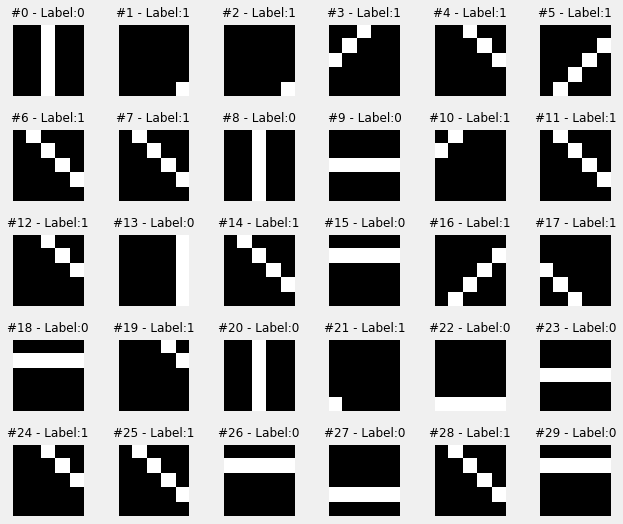

In [7]:
fig = plot_images(images, labels, n_plot=30)

In [8]:
image_r  = np.zeros((5, 5), dtype=np.uint8)
image_r[:, 0] = 255
image_r[:, 1] = 128
print(image_r)
image_g = np.zeros((5, 5), dtype=np.uint8)
image_g[:, 1] = 128
image_g[:, 2] = 255
image_g[:, 3] = 128
print(image_g)
image_b = np.zeros((5, 5), dtype=np.uint8)
image_b[:, 3] = 128
image_b[:, 4] = 255
print(image_b)

[[255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]
 [255 128   0   0   0]]
[[  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]
 [  0 128 255 128   0]]
[[  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]
 [  0   0   0 128 255]]


In [9]:
image_gray = .2126*image_r + .7152*image_g + .0722*image_b

In [11]:
np.stack([image_r, image_g, image_b], axis=2)

array([[[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]],

       [[255,   0,   0],
        [128, 128,   0],
        [  0, 255,   0],
        [  0, 128, 128],
        [  0,   0, 255]]], dtype=uint8)

In [12]:
image_rgb = np.stack([image_r, image_g, image_b], axis=2)

In [13]:
print(image_rgb.shape, image_rgb, sep='\n')

(5, 5, 3)
[[[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]

 [[255   0   0]
  [128 128   0]
  [  0 255   0]
  [  0 128 128]
  [  0   0 255]]]


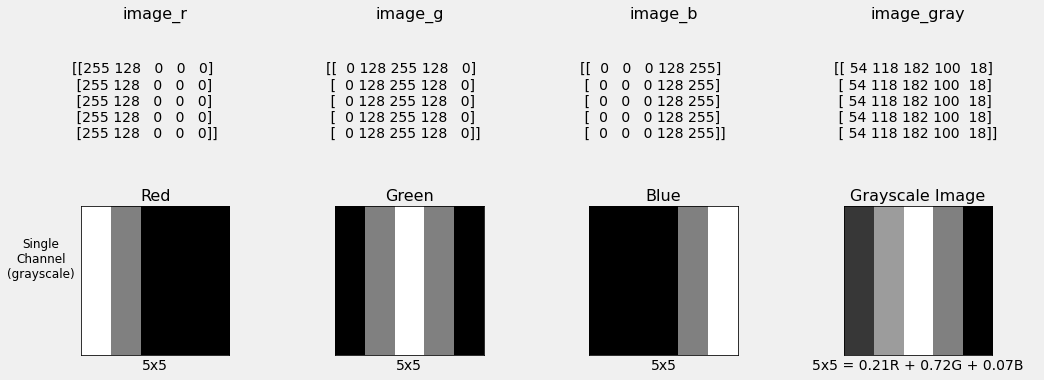

In [14]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 1))

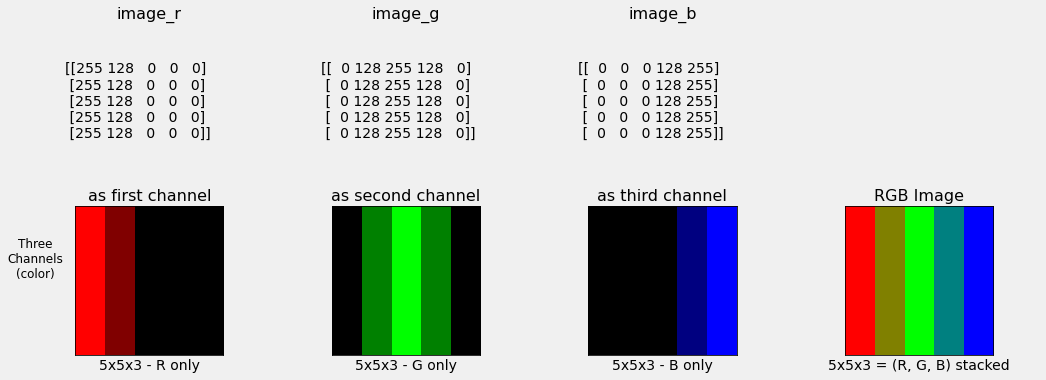

In [15]:
fig = image_channels(image_r, image_g, image_b, image_rgb, image_gray, rows=(0, 2))

In [16]:
images.shape

(300, 1, 5, 5)

In [22]:
example = images[7]
example.shape

(1, 5, 5)

In [23]:
example_hwc = np.transpose(example, (1, 2, 0))
example_hwc.shape

(5, 5, 1)

In [24]:
tensorizer = ToTensor()
example_tensor = tensorizer(example_hwc)
example_tensor.shape

torch.Size([1, 5, 5])

In [29]:
tensorizer(np.transpose(example, (1, 2, 0))).shape

torch.Size([1, 5, 5])

In [30]:
example_img = ToPILImage()(example_tensor)
print(type(example_img))

<class 'PIL.Image.Image'>


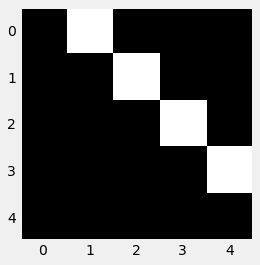

In [31]:
plt.imshow(example_img, cmap='gray')
plt.grid(False)

In [43]:
flipper = RandomHorizontalFlip(p=1.0)
flipped_img = flipper(example_img)

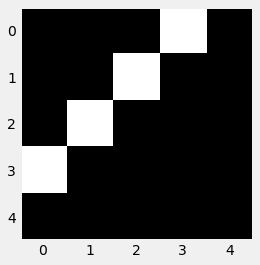

In [44]:
plt.imshow(flipped_img, cmap='gray')
plt.grid(False)

# Transforms on Tensor

In [45]:
img_tensor = tensorizer(flipped_img)
print(img_tensor.shape, img_tensor, sep='\n')

torch.Size([1, 5, 5])
tensor([[[0., 0., 0., 1., 0.],
         [0., 0., 1., 0., 0.],
         [0., 1., 0., 0., 0.],
         [1., 0., 0., 0., 0.],
         [0., 0., 0., 0., 0.]]])


# Normalize Transform

In [46]:
normalizer = Normalize(mean=(0.5,), std=(0.5,))
normalized_tensor = normalizer(img_tensor)
print(normalized_tensor)

tensor([[[-1., -1., -1.,  1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1.,  1., -1., -1., -1.],
         [ 1., -1., -1., -1., -1.],
         [-1., -1., -1., -1., -1.]]])


# Composing Transforms

In [47]:
composer = Compose([
                    RandomHorizontalFlip(p=0.1),
                    Normalize(mean=(0.5, ), std=(0.5, ))
])

In [48]:
composed_tensor = composer(example_tensor)
print(composed_tensor.shape, composed_tensor, sep='\n')

torch.Size([1, 5, 5])
tensor([[[-1.,  1., -1., -1., -1.],
         [-1., -1.,  1., -1., -1.],
         [-1., -1., -1.,  1., -1.],
         [-1., -1., -1., -1.,  1.],
         [-1., -1., -1., -1., -1.]]])


In [49]:
(composed_tensor == normalized_tensor).all()

tensor(False)

In [50]:
print(example)
print(example_tensor)

[[[  0 255   0   0   0]
  [  0   0 255   0   0]
  [  0   0   0 255   0]
  [  0   0   0   0 255]
  [  0   0   0   0   0]]]
tensor([[[0., 1., 0., 0., 0.],
         [0., 0., 1., 0., 0.],
         [0., 0., 0., 1., 0.],
         [0., 0., 0., 0., 1.],
         [0., 0., 0., 0., 0.]]])


# Data Preparation

In [51]:
# Build tensors from numpy arrays before split
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Dataset Transforms

In [52]:
class TransformedTensorDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform
  
  def __getitem__(self, index):
    x = self.x[index]
    if self.transform:
      x = self.transform(x)

    return x, self.y[index]

  def __len__(self):
    return len(self.x)

In [65]:
composer = Compose([
                    RandomHorizontalFlip(p=0.5),
                    Normalize(mean=(0.5, ), std=(0.5,))
])
dataset = TransformedTensorDataset(x_tensor, y_tensor, composer)

# SubsetRandomSample

In [53]:
def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)
  splits_tensor = torch.as_tensor(splits)
  multiplier = n / splits_tensor.sum()
  splits_tensor = (multiplier * splits_tensor).long()
  diff = n - splits_tensor.sum()
  splits_tensor[0] += diff
  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)

In [54]:
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
train_idx

In [60]:
train_idx.indices[:5]

[118, 170, 148, 239, 226]

In [61]:
train_sample = SubsetRandomSampler(train_idx)
val_sample = SubsetRandomSampler(val_idx)

In [63]:
train_sample

In [66]:
train_loader = DataLoader(dataset=dataset, batch_size=16, sampler=train_sample)
val_loader = DataLoader(dataset=dataset, batch_size=16, sampler=val_sample)

In [67]:
len(iter(train_loader)), len(iter(val_loader))

(15, 4)

# Data Augmentation Transformations

In [69]:
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]

x_val_tensor = x_tensor[val_idx]
y_vla_tensor = y_tensor[val_idx]

In [71]:
train_composer = Compose([
                          RandomHorizontalFlip(p=0.5),
                          Normalize(mean=(0.5, ), std=(0.5,))
])

val_composer = Compose([Normalize(mean=(0.5, ), std=(0.5,))])

In [72]:
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_vla_tensor, val_composer)

In [73]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

# WeightedRandomSample

In [75]:
classes, counts = y_train_tensor.unique(return_counts=True)
print(classes, counts, sep='\n')

tensor([0., 1.])
tensor([ 80, 160])


In [76]:
weights = 1.0 / counts.float()
weights

tensor([0.0125, 0.0063])

In [81]:
y_train_tensor.squeeze().long()

tensor([1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1,
        1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1,
        0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1,
        1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
        1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 0, 1, 1,
        0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
        1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1,
        1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1])

In [82]:
sample_weights = weights[y_train_tensor.squeeze().long()]

In [84]:
print(sample_weights.shape, sample_weights[:10], y_train_tensor[:10].squeeze(), sep='\n')

torch.Size([240])
tensor([0.0063, 0.0063, 0.0063, 0.0063, 0.0063, 0.0125, 0.0063, 0.0063, 0.0063,
        0.0063])
tensor([1., 1., 1., 1., 1., 0., 1., 1., 1., 1.])


In [86]:
generator = torch.Generator()

sampler = WeightedRandomSampler(
    weights = sample_weights,
    num_samples=len(sample_weights),
    generator=generator,
    replacement=True
)

In [87]:
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

# Putting it together

In [90]:

# To tensor
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# index spliter
def index_splitter(n, splits, seed=13):
  idx = torch.arange(n)
  splits_tensor = torch.as_tensor(splits)
  multiplier = n / splits_tensor.sum()
  splits_tensor = (multiplier * splits_tensor).long()
  diff = n - splits_tensor.sum()
  splits_tensor[0] += diff
  torch.manual_seed(seed)
  return random_split(idx, splits_tensor)

train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])

# Perform split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Build different composer becuase of data augmentation on training set
train_composer = Compose([
                          RandomHorizontalFlip(p=0.5),
                          Normalize(mean=(0.5, ), std=(0.5, ))
])
val_composer = Compose([Normalize(mean=(0.5, ), std=(0.5,))])


class TransformedTensorDataset(Dataset):
  def __init__(self, x, y, transform=None):
    self.x = x
    self.y = y
    self.transform = transform
  
  def __getitem__(self, index):
    x = self.x[index]
    if self.transform:
      x = self.transform(x)

    return x, self.y[index]

  def __len__(self):
    return len(self.x)

# compose transform dataset 
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, val_composer)

def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

# Build a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# balanced data loader
trian_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_laoder = DataLoader(dataset=val_dataset, batch_size=16)



# Pixels as Features

In [92]:
dummy_xs, dummy_ys = next(iter(train_loader))

dummy_xs.shape

torch.Size([16, 1, 5, 5])

In [98]:
flattener = nn.Flatten()

dummy_xs_flat = flattener(dummy_xs)
print(dummy_xs_flat.shape, dummy_xs_flat[0], sep='\n')

torch.Size([16, 25])
tensor([ 1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,
        -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.])


# Model Configuration

In [103]:
lr = 0.1

torch.manual_seed(42)

#Create model
model_logistic = nn.Sequential()
model_logistic.add_module('flatten', nn.Flatten())
model_logistic.add_module('output', nn.Linear(25, 1, bias=False))
model_logistic.add_module('sigmoid', nn.Sigmoid())

# Define optimizer
optimizer_logistic = optim.SGD(model_logistic.parameters(), lr = lr)

# Define loss
binary_loss_fn = nn.BCELoss()

# Model Training

In [122]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        # Here we define the attributes of our class
        
        # We start by storing the arguments as attributes 
        # to use them later
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        # Let's send the model to the specified device right away
        self.model.to(self.device)

        # These attributes are defined here, but since they are
        # not informed at the moment of creation, we keep them None
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        
        # These attributes are going to be computed internally
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0

        # Creates the train_step function for our model, 
        # loss function and optimizer
        # Note: there are NO ARGS there! It makes use of the class
        # attributes directly
        self.train_step = self._make_train_step()
        # Creates the val_step function for our model and loss
        self.val_step = self._make_val_step()

    def to(self, device):
        # This method allows the user to specify a different device
        # It sets the corresponding attribute (to be used later in
        # the mini-batches) and sends the model to the device
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        # This method allows the user to define which train_loader (and val_loader, optionally) to use
        # Both loaders are then assigned to attributes of the class
        # So they can be referred to later
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        # This method allows the user to define a SummaryWriter to interface with TensorBoard
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(folder, name, suffix))

    def _make_train_step(self):
        # This method does not need ARGS... it can refer to
        # the attributes: self.model, self.loss_fn and self.optimizer
        
        # Builds function that performs a step in the train loop
        def perform_train_step(x, y):
            # Sets model to TRAIN mode
            self.model.train()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # Step 3 - Computes gradients for both "a" and "b" parameters
            loss.backward()
            # Step 4 - Updates parameters using gradients and the learning rate
            self.optimizer.step()
            self.optimizer.zero_grad()

            # Returns the loss
            return loss.item()

        # Returns the function that will be called inside the train loop
        return perform_train_step
    
    def _make_val_step(self):
        # Builds function that performs a step in the validation loop
        def perform_val_step(x, y):
            # Sets model to EVAL mode
            self.model.eval()

            # Step 1 - Computes our model's predicted output - forward pass
            yhat = self.model(x)
            # Step 2 - Computes the loss
            loss = self.loss_fn(yhat, y)
            # There is no need to compute Steps 3 and 4, since we don't update parameters during evaluation
            return loss.item()

        return perform_val_step
            
    def _mini_batch(self, validation=False):
        # The mini-batch can be used with both loaders
        # The argument `validation`defines which loader and 
        # corresponding step function is going to be used
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader is None:
            return None
            
        # Once the data loader and step function, this is the same
        # mini-batch loop we had before
        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)

            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)

        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False    
        torch.manual_seed(seed)
        np.random.seed(seed)
    
    def train(self, n_epochs, seed=42):
        # To ensure reproducibility of the training process
        self.set_seed(seed)

        for epoch in range(n_epochs):
            # Keeps track of the numbers of epochs
            # by updating the corresponding attribute
            self.total_epochs += 1

            # inner loop
            # Performs training using mini-batches
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)

            # VALIDATION
            # no gradients in validation!
            with torch.no_grad():
                # Performs evaluation using mini-batches
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)

            # If a SummaryWriter has been set...
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                # Records both losses for each epoch under the main tag "loss"
                self.writer.add_scalars(main_tag='loss',
                                        tag_scalar_dict=scalars,
                                        global_step=epoch)

        if self.writer:
            # Closes the writer
            self.writer.close()

    def save_checkpoint(self, filename):
        # Builds dictionary with all elements for resuming training
        checkpoint = {'epoch': self.total_epochs,
                      'model_state_dict': self.model.state_dict(),
                      'optimizer_state_dict': self.optimizer.state_dict(),
                      'loss': self.losses,
                      'val_loss': self.val_losses}

        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        # Loads dictionary
        checkpoint = torch.load(filename)

        # Restore state for model and optimizer
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])

        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']

        self.model.train() # always use TRAIN for resuming training   

    def predict(self, x):
        # Set is to evaluation mode for predictions
        self.model.eval() 
        # Takes aNumpy input and make it a float tensor
        x_tensor = torch.as_tensor(x).float()
        # Send input to device and uses model for prediction
        y_hat_tensor = self.model(x_tensor.to(self.device))
        # Set it back to train mode
        self.model.train()
        # Detaches it, brings it to CPU and back to Numpy
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        # Fetches a single mini-batch so we can use add_graph
        if self.train_loader and self.writer:
            x_sample, y_sample = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_sample.to(self.device))

In [104]:
n_epochs = 100

sbs_logistic = StepByStep(model_logistic, binary_loss_fn, optimizer_logistic)
sbs_logistic.set_loaders(train_loader, val_loader)
sbs_logistic.train(n_epochs)

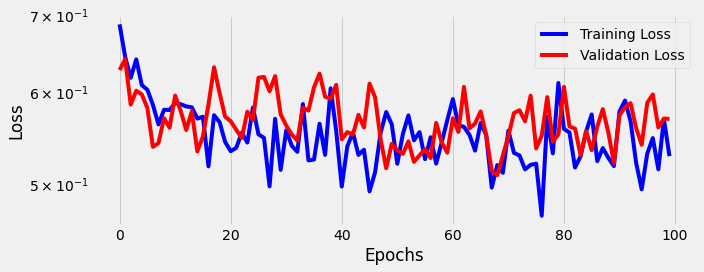

In [105]:
fig = sbs_logistic.plot_losses()

# Model configuration

In [106]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_nn = nn.Sequential()
model_nn.add_module('flatten', nn.Flatten())
model_nn.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_nn.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_nn.add_module('output', nn.Linear(3, 1, bias=False))
model_nn.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters 
optimizer_nn = optim.SGD(model_nn.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [107]:
n_epochs = 100

sbs_nn = StepByStep(model_nn, binary_loss_fn, optimizer_nn)
sbs_nn.set_loaders(train_loader, val_loader)
sbs_nn.train(n_epochs)

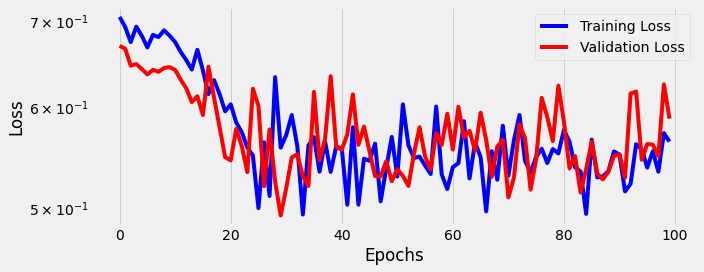

In [109]:
fig = sbs_nn.plot_losses()

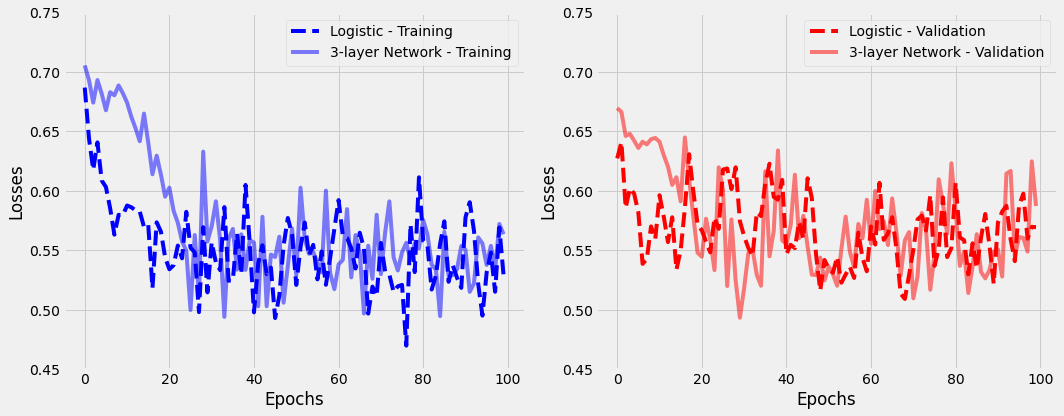

In [110]:
fig = figure5(sbs_logistic, sbs_nn)

# Weights

In [111]:
w_nn_hidden0 = model_nn.hidden0.weight.detach()
w_nn_hidden1 = model_nn.hidden1.weight.detach()
w_nn_output = model_nn.output.weight.detach()

w_nn_hidden0.shape, w_nn_hidden1.shape, w_nn_output.shape

(torch.Size([5, 25]), torch.Size([3, 5]), torch.Size([1, 3]))

In [112]:
w_nn_equiv = w_nn_output @ w_nn_hidden1 @ w_nn_hidden0
w_nn_equiv.shape

torch.Size([1, 25])

In [113]:
w_nn_equiv = w_nn_output.mm(w_nn_hidden1.mm(w_nn_hidden0))

In [114]:
w_logistic_output = model_logistic.output.weight.detach()

w_logistic_output.shape

torch.Size([1, 25])

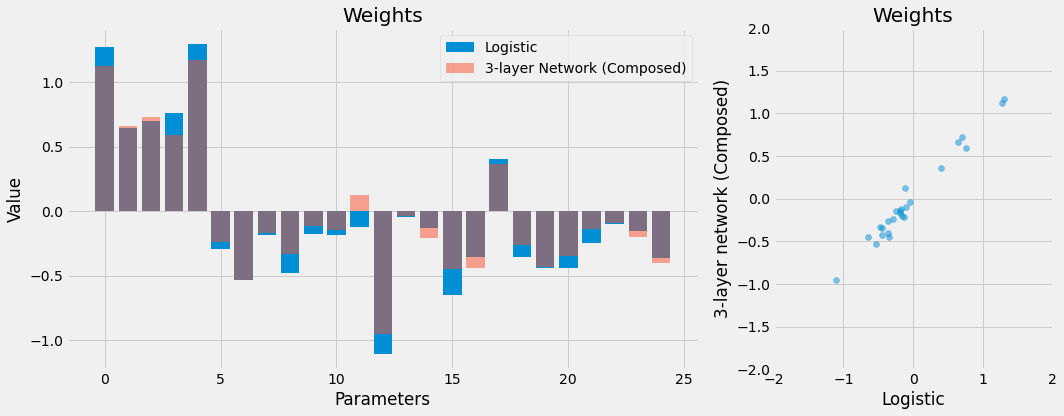

In [115]:
fig = weights_comparison(w_logistic_output, w_nn_equiv)

In [123]:
def count_parameters(self):
    return sum(p.numel() for p in self.model.parameters() if p.requires_grad)

setattr(StepByStep, 'count_parameters', count_parameters)

In [124]:
sbs_logistic.count_parameters(), sbs_nn.count_parameters()

AttributeError: ignored

# Weights as Pixels

In [125]:
w_nn_hidden0.shape

torch.Size([5, 25])

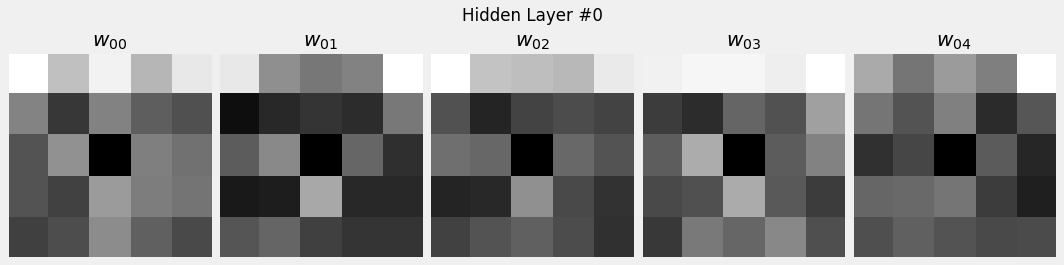

In [126]:
fig = figure7(w_nn_hidden0)

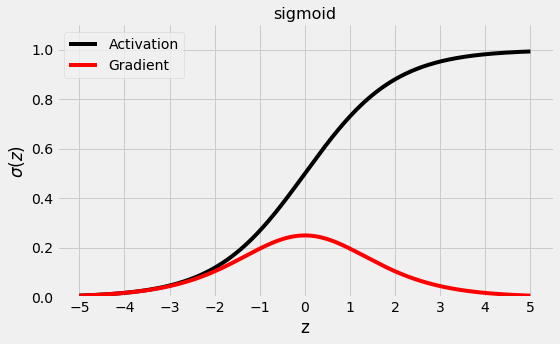

In [127]:
fig = plot_activation(torch.sigmoid)

In [128]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.sigmoid(dummy_z)

tensor([0.0474, 0.5000, 0.9526])

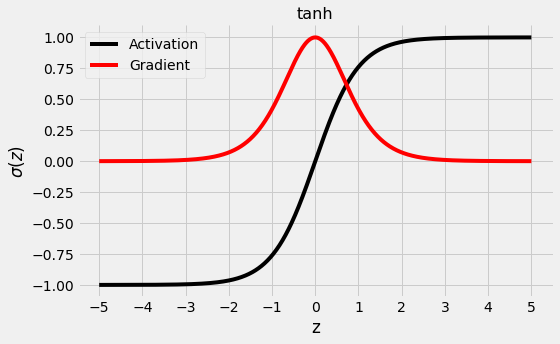

In [129]:
fig = plot_activation(torch.tanh)

In [130]:
dummy_z = torch.tensor([-3., 0., 3.])
torch.tanh(dummy_z)

tensor([-0.9951,  0.0000,  0.9951])

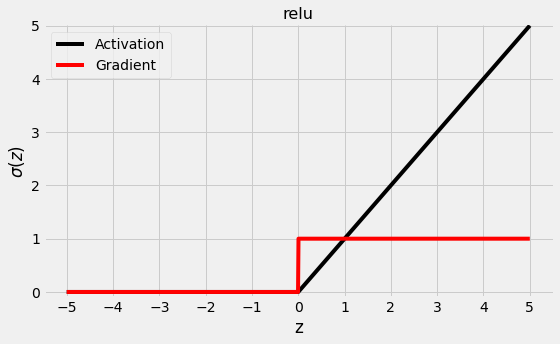

In [131]:
fig = plot_activation(torch.relu)

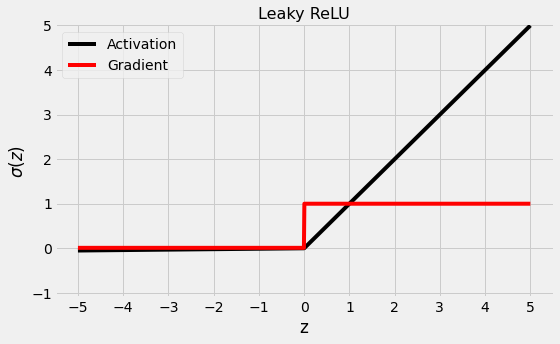

In [132]:
fig = plot_activation(nn.LeakyReLU(), name='Leaky ReLU')

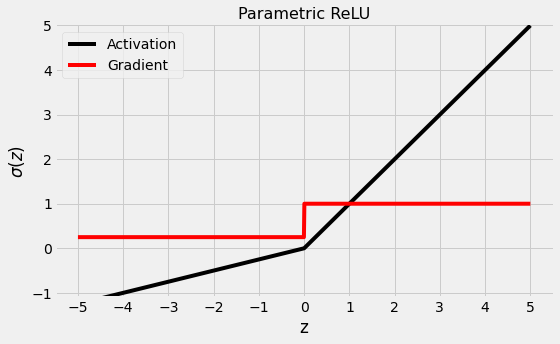

In [133]:
fig = plot_activation(nn.PReLU(), name='Parametric ReLU')

# Deep model

In [141]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(17)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [142]:
n_epochs = 100

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

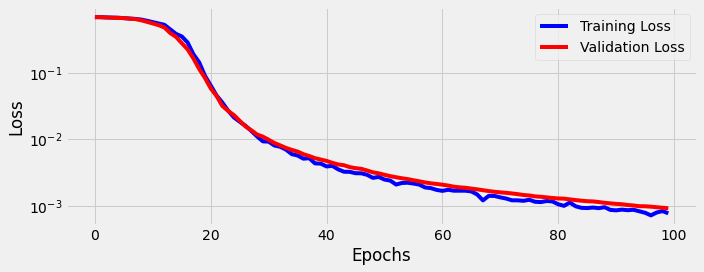

In [143]:
fig = sbs_relu.plot_losses()

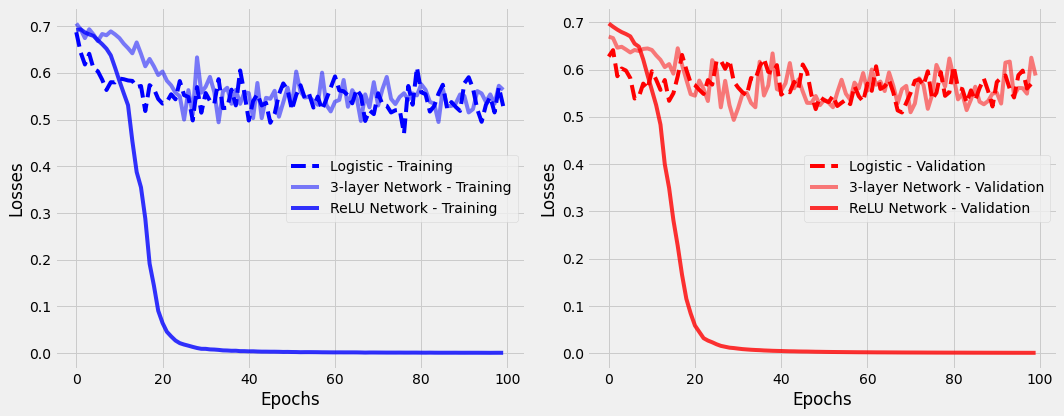

In [144]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)

# PUt it all together

In [145]:
class TransformedTensorDataset(Dataset):
    def __init__(self, x, y, transform=None):
        self.x = x
        self.y = y
        self.transform = transform
        
    def __getitem__(self, index):
        x = self.x[index]
        
        if self.transform:
            x = self.transform(x)
        
        return x, self.y[index]
        
    def __len__(self):
        return len(self.x)

In [146]:
def index_splitter(n, splits, seed=13):
    idx = torch.arange(n)
    # Makes the split argument a tensor
    splits_tensor = torch.as_tensor(splits)
    # Finds the correct multiplier, so we don't have
    # to worry about summing up to N (or one)
    multiplier = n / splits_tensor.sum()    
    splits_tensor = (multiplier * splits_tensor).long()
    # If there is a difference, throws at the first split
    # so random_split does not complain
    diff = n - splits_tensor.sum()
    splits_tensor[0] += diff
    # Uses PyTorch random_split to split the indices
    torch.manual_seed(seed)
    return random_split(idx, splits_tensor)

In [147]:
def make_balanced_sampler(y):
    # Computes weights for compensating imbalanced classes
    classes, counts = y.unique(return_counts=True)
    weights = 1.0 / counts.float()
    sample_weights = weights[y.squeeze().long()]
    # Builds sampler with compute weights
    generator = torch.Generator()
    sampler = WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        generator=generator,
        replacement=True
    )
    return sampler

In [148]:
# Builds tensors from numpy arrays BEFORE split
# Modifies the scale of pixel values from [0, 255] to [0, 1]
x_tensor = torch.as_tensor(images / 255).float()
y_tensor = torch.as_tensor(labels.reshape(-1, 1)).float()

# Uses index_splitter to generate indices for training and
# validation sets
train_idx, val_idx = index_splitter(len(x_tensor), [80, 20])
# Uses indices to perform the split
x_train_tensor = x_tensor[train_idx]
y_train_tensor = y_tensor[train_idx]
x_val_tensor = x_tensor[val_idx]
y_val_tensor = y_tensor[val_idx]

# Builds different composers because of data augmentation on training set
train_composer = Compose([RandomHorizontalFlip(p=.5),
                          Normalize(mean=(.5,), std=(.5,))])
val_composer = Compose([Normalize(mean=(.5,), std=(.5,))])
# Uses custom dataset to apply composed transforms to each set
train_dataset = TransformedTensorDataset(x_train_tensor, y_train_tensor, transform=train_composer)
val_dataset = TransformedTensorDataset(x_val_tensor, y_val_tensor, transform=val_composer)

# Builds a weighted random sampler to handle imbalanced classes
sampler = make_balanced_sampler(y_train_tensor)

# Uses sampler in the training set to get a balanced data loader
train_loader = DataLoader(dataset=train_dataset, batch_size=16, sampler=sampler)
val_loader = DataLoader(dataset=val_dataset, batch_size=16)

In [153]:
# Sets learning rate - this is "eta" ~ the "n" like Greek letter
lr = 0.1

torch.manual_seed(11)
# Now we can create a model
model_relu = nn.Sequential()
model_relu.add_module('flatten', nn.Flatten())
model_relu.add_module('hidden0', nn.Linear(25, 5, bias=False))
model_relu.add_module('activation0', nn.ReLU())
model_relu.add_module('hidden1', nn.Linear(5, 3, bias=False))
model_relu.add_module('activation1', nn.ReLU())
model_relu.add_module('output', nn.Linear(3, 1, bias=False))
model_relu.add_module('sigmoid', nn.Sigmoid())

# Defines a SGD optimizer to update the parameters
# (now retrieved directly from the model)
optimizer_relu = optim.SGD(model_relu.parameters(), lr=lr)

# Defines a binary cross entropy loss function
binary_loss_fn = nn.BCELoss()

In [154]:
n_epochs = 100

sbs_relu = StepByStep(model_relu, binary_loss_fn, optimizer_relu)
sbs_relu.set_loaders(train_loader, val_loader)
sbs_relu.train(n_epochs)

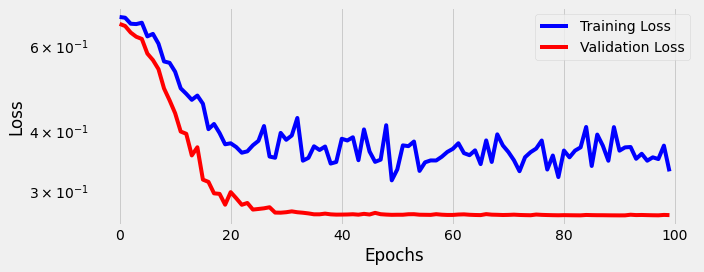

In [155]:
fig = sbs_relu.plot_losses()

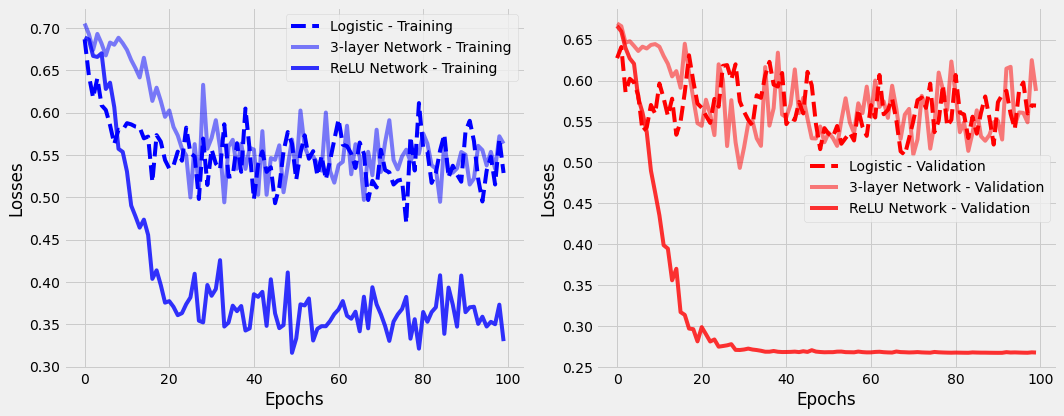

In [156]:
fig = figure5b(sbs_logistic, sbs_nn, sbs_relu)